In [1]:
from timeit import default_timer as timer
start = timer()

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.datasets import cifar10 as cf10

import matplotlib.pylab as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-10-10 21:05:50.639287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 21:05:51.921155: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nilray/miniconda3/envs/tf-gpu/lib/
2023-10-10 21:05:51.924084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nilray/miniconda3/envs/tf-gpu/lib/
2023-10-10 21:05:51.924104: W tensorflow/compi

In [3]:
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.11.1


In [4]:
# Load image data from CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cf10.load_data()

In [5]:
# Define helper function to view images
def show_images(train_images,class_names,train_labels,nb_samples=12, nb_row=4):
    plt.figure(figsize=(12,12))
    for i in range(nb_samples):
        plt.subplot(nb_row,nb_row,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i],cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[i][0]])
    plt.show()
    

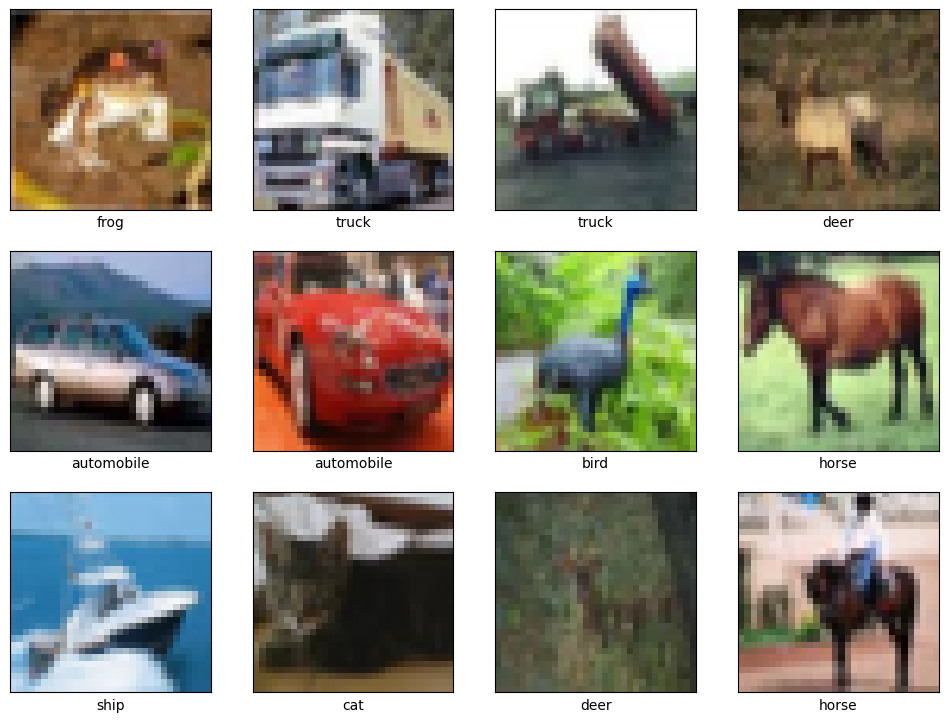

In [6]:
#Show samples images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog','frog','horse','ship','truck']
show_images(train_images, class_names,train_labels)

In [7]:
# Data pre-processing
# normalize pixel values between 0 and 1
max_pixel_value = 255

train_images = train_images / max_pixel_value
test_images = test_images / max_pixel_value

In [8]:
# convert labels from text to one-hot vectors
train_labels = tf.keras.utils.to_categorical(train_labels, len(class_names))
test_labels = tf.keras.utils.to_categorical(test_labels, len(class_names))

In [9]:
# Define the model architecture

#Constants
INPUT_SHAPE = (32,32,3)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3,3)
POOL_SHAPE = (2,2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = len(class_names)

model = tf.keras.models.Sequential()
model.add(tfl.Conv2D(FILTER1_SIZE,FILTER_SHAPE,activation='relu',input_shape=INPUT_SHAPE))
model.add(tfl.MaxPooling2D(POOL_SHAPE))
model.add(tfl.Conv2D(FILTER2_SIZE,FILTER_SHAPE,activation='relu'))
model.add(tfl.MaxPooling2D(POOL_SHAPE))
model.add(tfl.Flatten())
model.add(tfl.Dense(FULLY_CONNECT_NUM,activation='relu'))
model.add(tfl.Dropout(rate=0.2))
model.add(tfl.Dense(NUM_CLASSES,activation='softmax'))

model.summary()

2023-10-10 21:05:56.562973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 21:05:56.610187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 21:05:56.610284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 21:05:56.610912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [10]:
#Model compiling

BATCH_SIZE = 64
EPOCHS = 30
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
           ]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)


In [11]:
# model training

training_history = model.fit(x=train_images,
                             y=train_labels,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE,
                             validation_data=(test_images, test_labels))


2023-10-10 21:05:59.097568: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2023-10-10 21:06:00.828913: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/30


2023-10-10 21:06:04.008758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-10-10 21:06:05.888239: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-10 21:06:07.153289: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x30032680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-10 21:06:07.153336: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2023-10-10 21:06:07.160604: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-10 21:06:07.280913: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-10 21:06:07.326427: I tensorflow/compiler/jit/xla_compilatio

782/782 [==============================] - 16s 11ms/step - loss: 1.5488 - accuracy: 0.4369 - precision: 0.6805 - recall: 0.1906 - val_loss: 1.2864 - val_accuracy: 0.5441 - val_precision: 0.7366 - val_recall: 0.3445
Epoch 2/30
782/782 [==============================] - 8s 10ms/step - loss: 1.1923 - accuracy: 0.5767 - precision: 0.7447 - recall: 0.3934 - val_loss: 1.0582 - val_accuracy: 0.6266 - val_precision: 0.7748 - val_recall: 0.4706
Epoch 3/30
782/782 [==============================] - 8s 10ms/step - loss: 1.0423 - accuracy: 0.6329 - precision: 0.7734 - recall: 0.4857 - val_loss: 0.9704 - val_accuracy: 0.6611 - val_precision: 0.7868 - val_recall: 0.5203
Epoch 4/30
782/782 [==============================] - 8s 10ms/step - loss: 0.9568 - accuracy: 0.6639 - precision: 0.7896 - recall: 0.5325 - val_loss: 0.9360 - val_accuracy: 0.6746 - val_precision: 0.7933 - val_recall: 0.5523
Epoch 5/30
782/782 [==============================] - 8s 10ms/step - loss: 0.8907 - accuracy: 0.6879 - precisi

In [12]:
# model evaluation helper function

def show_performance_curve(training_result, metric, metric_label):
    train_perf = training_result.history[str(metric)]
    validation_perf = training_result.history['val_'+str(metric)]
    #intersection_idx = np.argwhere(np.isclose(train_perf,validation_perf,atol=1e-2)).flatten()[0]
    #intersection_value = train_perf[intersection_idx]
    
    plt.plot(train_perf, label=metric_label)
    plt.plot(validation_perf,label='val_'+str(metric))
    
    #plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')
    
    # plt.annotate(f'Optimal value: {intersection_value:.4f}',
    #              xy=(intersection_idx,intersection_value),
    #              xycoords='data',
    #              fontsize=10,
    #              color = 'green')
    plt.xlabel('Epoch')
    plt.ylabel(metric_label)
    plt.legend(loc='lower right')

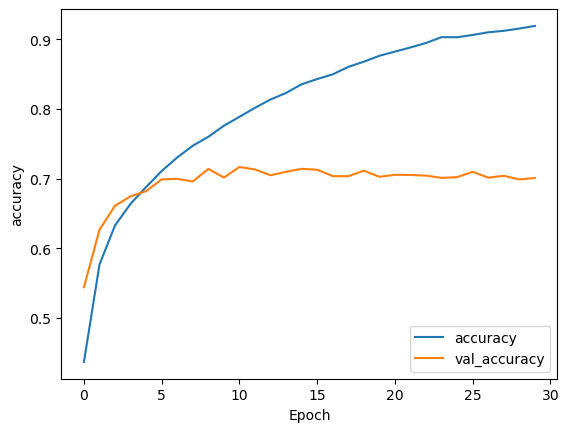

In [13]:
# Plot performance for "Accuracy" 
show_performance_curve(training_history,'accuracy','accuracy')

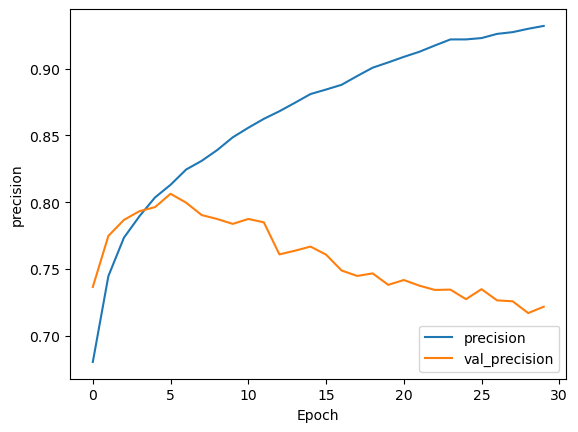

In [14]:
# Plot performance for "Precision" 
show_performance_curve(training_history,'precision','precision')

313/313 [==============================] - 1s 2ms/step


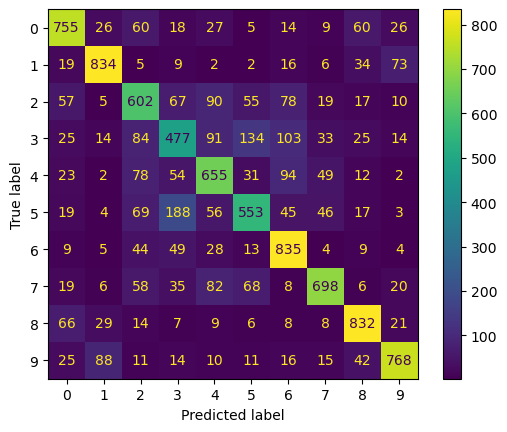

In [15]:
#Confusion matrix

test_predictions = model.predict(test_images)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels,axis=1)

cm = confusion_matrix(test_true_labels, test_predicted_labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

In [16]:
end = timer()
print("--- %s seconds ---" % (end-start))

--- 279.5909551220029 seconds ---
